# Image segmentation by $k$-means

The objective of this lab is to show how to use $k$-means to segment images. 

You will find below the code for segmenting a greyscale image into $k$ images, each with a specific grey level, by $k$-means clustering. We refer to each such image as a **mask**.

## To do

1. Apply $k$-means to each mask so as to identify different parts / objects of the original image. Test on various images.
2. Adapt the method to color images.


## Import packages

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy as sp

## Load images

In [3]:
# load the raccoon image as a numpy array
try:
    face = -sp.face(gray=True)
except AttributeError:
    from scipy import misc
    face = -misc.face(gray=True)

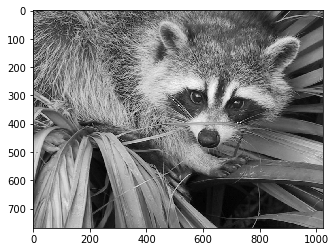

In [4]:
plt.imshow(face, cmap='binary')
plt.show()

In [5]:
img = face[:500,400:900]

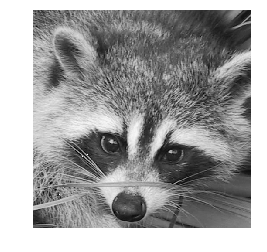

In [6]:
plt.imshow(img,cmap = 'binary')
plt.axis('off')
plt.show()

## Clustering

In [26]:
class kmeans:
    '''k-means algorithm
    
    Parameters
    ----------
    n_clusters: int, default: 8
        Number of clusters.
    
    n_init : int, default: 10
        Number of instances of k-means, each with different initial centers. 
        The output is that of the best instance (in terms of inertia).
    
    n_iter: int, default: 300
        Number of iterations for each instance of k-means.
        
    algorithm: "random" or "++", default:"++"
        Algorithm for initializing the centers; "++" corresponds to k-means++.
    
    seed: int, default: None
        Seed for the random generation of initial centers.
        
    verbose : boolean, optional
        Verbose mode.
    
    Attributes
    ----------
    clusters_: array, shape(n_samples,)
        Cluster index of each sample.
        
    centers_ : array, shape(n_clusters, n_features)
        Cluster centers.
        
    inertias_: array, shape(n_clusters,)
        Cluster inertias (sum of square distances).
    '''

    def __init__(self, n_clusters=8, n_init=10, n_iter=300, algorithm='++', seed=None, verbose = False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.n_iter = n_iter
        self.algorithm = algorithm
        self.seed = seed
        self.verbose = verbose
        self.labels_ = None
        self.centers_ = None
        self.inertias_ = None
       
    def fit(self, X):
        '''Cluster data X using k-means
    
        Parameters
        ----------
        X: array, shape(n_samples,n_features)
            Data to cluster.
        '''        
        
        def init_centers(self, X):
            if self.algorithm == 'random':
                # random centers 
                samples = np.random.choice(X.shape[0], size = self.n_clusters)
                centers = X[samples]
            else:
                # k-means++
                centers = np.zeros((self.n_clusters, X.shape[1]))
                sample = np.random.choice(X.shape[0])
                centers[0] = X[sample]
                distance = np.full(X.shape[0], np.inf)
                for j in range(1,self.n_clusters):
                    distance = np.minimum(np.linalg.norm(X - centers[j], axis=1), distance)
                    p = np.square(distance) / np.sum(np.square(distance))
                    sample = np.random.choice(X.shape[0], p = p)
                    centers[j] = X[sample]
            return centers
        
        def compute_centers(self, X, clusters):
            centers = []
            for j in range(self.n_clusters):
                index = np.where(clusters == j)[0]
                if len(index):
                    centers.append(np.mean(X[index],axis = 0))
                else:
                    # reinit center in case of empty cluster
                    centers.append(X[np.random.choice(X.shape[0])])
            return np.array(centers)

        def compute_distances(self, X, centers):
            distances = []
            for j in range(self.n_clusters):
                distances.append(np.linalg.norm(X - centers[j], axis=1))
            return np.array(distances)
            
        def compute_inertias(self, X, centers, clusters):
            inertias = []
            for j in range(self.n_clusters):
                index = np.where(clusters == j)[0]
                inertias.append(np.sum(np.square(np.linalg.norm(X[index] - centers[j], axis=1))))
            return np.array(inertias)
    
        def single_run_kmeans(self, X):
            centers = init_centers(self, X)
            for i in range(self.n_iter):
                centers_old = centers.copy()
                distances = compute_distances(self, X, centers)
                clusters = np.argmin(distances, axis=0)  
                centers = compute_centers(self, X, clusters)
                if np.array_equal(centers, centers_old):
                    break
            inertias = compute_inertias(self, X, centers, clusters)
            return clusters, centers, inertias
            
        np.random.seed(self.seed)
        best_inertia = None
        # select the best instance of k-means
        for i in range(self.n_init):
            if self.verbose:
                print("Instance ",i)
            clusters, centers, inertias = single_run_kmeans(self, X)
            inertia = np.sum(inertias)
            if best_inertia is None or inertia < best_inertia:
                best_clusters = clusters.copy()
                best_centers = centers.copy()
                best_inertias = inertias.copy()
                best_inertia = inertia

        self.clusters_ = best_clusters
        self.centers_ = best_centers
        self.inertias_ = best_inertias
        return self

## Application to greyscale image

In [27]:
k = 4

In [28]:
km = kmeans(n_clusters=k, n_init=5, n_iter=100, verbose = True)

In [29]:
# 1D array
X = img.reshape((-1,1))

In [30]:
km.fit(X)

Instance  0
Instance  1
Instance  2
Instance  3
Instance  4


In [31]:
km.centers_

array([[108.67081305],
       [198.61877628],
       [ 55.74716395],
       [155.55008575]])

In [32]:
X_ = km.centers_[km.clusters_]
X_ = np.clip(X_.astype('uint8'), 0, 255)

In [34]:
img_ = X_.reshape(img.shape)

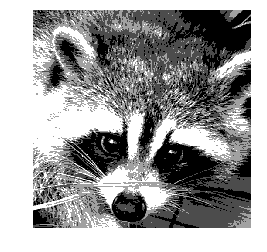

In [35]:
plt.imshow(img_,cmap = 'binary')
plt.axis('off')
plt.show()

In [59]:
def get_masks(img, km):
    masks = []
    for j in range(km.n_clusters):
        X_ = (km.clusters_ == j) * km.centers_[j]
        X_ = np.clip(X_.astype('uint8'), 0, 255)
        masks.append(X_.reshape(img.shape))
    return masks

In [40]:
masks = get_masks(img, km)

In [42]:
def show_masks(masks):
    for img in masks:
        plt.figure()
        plt.imshow(img, cmap = 'binary', vmin = 0, vmax = 255)
        plt.axis('off')
        plt.show()

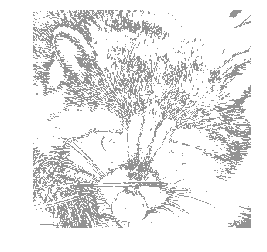

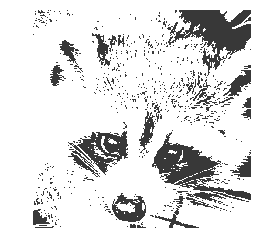

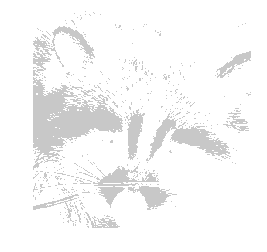

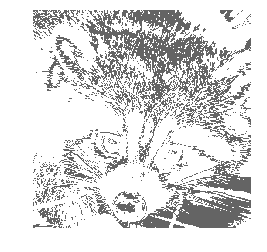

In [43]:
show_masks(masks)

## Application to color image

In [105]:
import os.path
from urllib.request import urlretrieve as download

In [106]:
filename = 'flower.jpg'
if not os.path.isfile(filename):
    download('http://farm3.static.flickr.com/2024/2527645219_a4931e5a26.jpg', filename)

In [107]:
download('http://farm3.static.flickr.com/2024/2527645219_a4931e5a26.jpg', 'flower.jpg')

('flower.jpg', <http.client.HTTPMessage at 0xb1c671978>)

### In 1 dimension

In [108]:
img = imread('./flower.jpg')
# 2D array
X = img.reshape(-1,1)

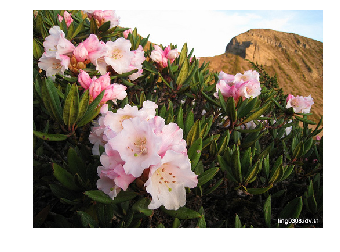

In [109]:
plt.imshow(img)
plt.axis('off')
plt.show()

Instance  0
Instance  1
Instance  2
Instance  3
Instance  4


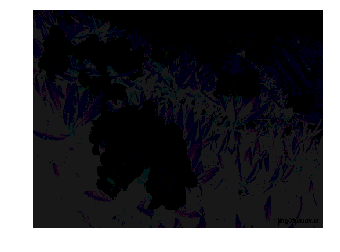

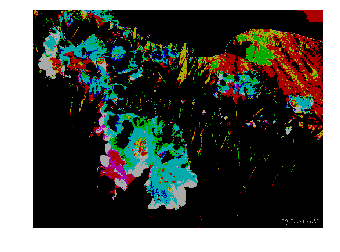

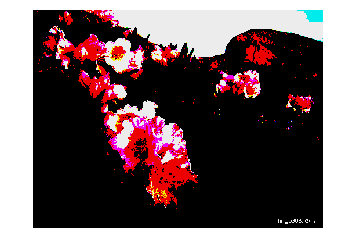

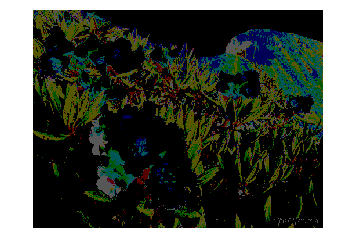

In [110]:
km = kmeans(n_clusters=4, n_init=5, n_iter=100, verbose = True)
km.fit(X)
X_ = km.centers_[km.clusters_]
X_ = np.clip(X_.astype('uint8'), 0, 255)
img_ = X_.reshape(img.shape)
masks = get_masks(img_, km)
show_masks(masks)

### In 3 Dimensions

In [157]:
X = img.reshape(-1,3)

In [158]:
X_ = []
for i in [0,1,2] :
    km = kmeans(n_clusters=3, n_init=5, n_iter=100)
    km.fit(X[:,i].reshape(-1,1))
    X_sub = (km.centers_[km.clusters_])
    X_.append(np.clip(X_sub.astype('uint8'), 0, 255))

In [159]:
X_ = np.concatenate((X_[0], X_[1], X_[2]), axis=1).flatten()

In [160]:
img_ = X_.reshape(img.shape)

In [161]:
img_.shape

(375, 500, 3)

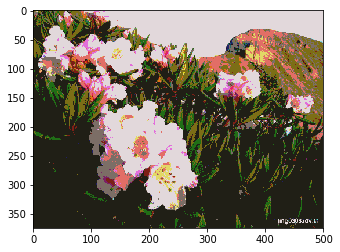

In [162]:
plt.imshow(img_)